In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from math import nan

from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


from core.classes import FeatureEngineer, DataImputation

pd.set_option('display.max_columns', None)

In [26]:
path = '../data/processed/combined_data.csv'
df = pd.read_csv(path, index_col='date', skipfooter=1)


C:\Users\judit\AppData\Local\Temp\ipykernel_19100\3028427092.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, index_col='date', skipfooter=1)


In [41]:
demand = (df.iloc[:, 44])
price = df.iloc[:, 121]
demand_change = demand.pct_change()
price_change = price.pct_change()
elasticity = demand_change / price_change
df['elasticity'] = elasticity

demand_coffee = (df.iloc[:, 62])
price_coffee = df.iloc[:, 143]
demand_change_coffee = demand_coffee.pct_change()
price_change_coffee = price_coffee.pct_change()
elasticity_coffee = demand_change_coffee / price_change_coffee
df['elasticity_coffee'] = elasticity_coffee

In [42]:
df

,Betriebe_WZ08-10,Betriebe_ep_WZ08-10,Beschäftigte_WZ08-10,Beschäftigte_ep_WZ08-10,Geleistete Arbeitsstunden_WZ08-10,Geleistete Arbeitsstunden_ep_WZ08-10,Bruttolohn- und -gehaltssumme_WZ08-10,Bruttolohn- und -gehaltssumme_ep_WZ08-10,Umsatz_WZ08-10,Umsatz_ep_WZ08-10,Inlandsumsatz_WZ08-10,Inlandsumsatz_ep_WZ08-10,Auslandsumsatz_WZ08-10,Auslandsumsatz_ep_WZ08-10,Auslandsumsatz mit der Eurozone_WZ08-10,Auslandsumsatz mit der Eurozone_ep_WZ08-10,Auslandsumsatz mit dem sonstigen Ausland_WZ08-10,Auslandsumsatz mit dem sonstigen Ausland_ep_WZ08-10,Betriebe_WZ08-108,Betriebe_ep_WZ08-108,Beschäftigte_WZ08-108,Beschäftigte_ep_WZ08-108,Geleistete Arbeitsstunden_WZ08-108,Geleistete Arbeitsstunden_ep_WZ08-108,Bruttolohn- und -gehaltssumme_WZ08-108,Bruttolohn- und -gehaltssumme_ep_WZ08-108,Umsatz_WZ08-108,Umsatz_ep_WZ08-108,Inlandsumsatz_WZ08-108,Inlandsumsatz_ep_WZ08-108,Auslandsumsatz_WZ08-108,Auslandsumsatz_ep_WZ08-108,Auslandsumsatz mit der Eurozone_WZ08-108,Auslandsumsatz mit der Eurozone_ep_WZ08-108,Auslandsumsatz mit dem sonstigen Ausland_WZ08-108,Auslandsumsatz mit dem sonstigen Ausland_ep_WZ08-108,Betriebe_WZ08-1082,Betriebe_ep_WZ08-1082,Beschäftigte_WZ08-1082,Beschäftigte_ep_WZ08-1082,Geleistete Arbeitsstunden_WZ08-1082,Geleistete Arbeitsstunden_ep_WZ08-1082,Bruttolohn- und -gehaltssumme_WZ08-1082,Bruttolohn- und -gehaltssumme_ep_WZ08-1082,Umsatz_WZ08-1082,Umsatz_ep_WZ08-1082,Inlandsumsatz_WZ08-1082,Inlandsumsatz_ep_WZ08-1082,Auslandsumsatz_WZ08-1082,Auslandsumsatz_ep_WZ08-1082,Auslandsumsatz mit der Eurozone_WZ08-1082,Auslandsumsatz mit der Eurozone_ep_WZ08-1082,Auslandsumsatz mit dem sonstigen Ausland_WZ08-1082,Auslandsumsatz mit dem sonstigen Ausland_ep_WZ08-1082,Betriebe_WZ08-1083,Betriebe_ep_WZ08-1083,Beschäftigte_WZ08-1083,Beschäftigte_ep_WZ08-1083,Geleistete Arbeitsstunden_WZ08-1083,Geleistete Arbeitsstunden_ep_WZ08-1083,Bruttolohn- und -gehaltssumme_WZ08-1083,Bruttolohn- und -gehaltssumme_ep_WZ08-1083,Umsatz_WZ08-1083,Umsatz_ep_WZ08-1083,Inlandsumsatz_WZ08-1083,Inlandsumsatz_ep_WZ08-1083,Auslandsumsatz_WZ08-1083,Auslandsumsatz_ep_WZ08-1083,Auslandsumsatz mit der Eurozone_WZ08-1083,Auslandsumsatz mit der Eurozone_ep_WZ08-1083,Auslandsumsatz mit dem sonstigen Ausland_WZ08-1083,Auslandsumsatz mit dem sonstigen Ausland_ep_WZ08-1083,ErzPr_Nahrungsmittel und Futtermittel,ErzPr_Sonstige Nahrungsmittel (ohne Getränke),ErzPr_Süßwaren (ohne Dauerbackwaren),ErzPr_Schokoladen und andere Süßwaren,"ErzPr_Schokolade u.a. kakaoh. Lebensm.zub.,in Verp.>2kg","ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg",ErzPr_Süßwaren oh. Kakaogeh. (einschl.weißer Schokolade),"ErzPr_Kaffee und Tee, Kaffee-Ersatz","ErzPr_Kaffee und Tee, Kaffee-Ersatz.1","ErzPr_Kaffee, entkoffeiniert oder geröstet","ErzPr_Kaffeemittel m. -geh.,Auszüge,Essenz.,Konzentrate","ErzPr_Grüner Tee (n. ferment.), schwarzer Tee (ferment.)",ErzPr_Kräutertees,EinfPr_Nahrungsmittel und Futtermittel,EinfPr_Sonstige Nahrungsmittel (ohne Getränke),EinfPr_Süßwaren (ohne Dauerbackwaren),"EinfPr_Kaffee und Tee, Kaffee-Ersatz",VPI_Nahrungsmittel und alkoholfreie Getränke,VPI_Nahrungsmittel,"VPI_Zucker, Marmelade, Honig und andere Süßwaren",VPI_Schokoladen,VPI_Süßwaren,VPI_Alkoholfreie Getränke,"VPI_Kaffee, Tee und Kakao",VPI_Kaffee und Ähnliches,VPI_Tee und teeähnliche Erzeugnisse,VPI_Kakaopulver oder Ähnliches,"Wert der zum Absatz bestimmten Produktion_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Wert der zum Absatz bestimmten Produktion_ep_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Gewicht der zum Absatz bestimmten Produktion_t_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Gewicht der zum Absatz bestimmten Produktion_t_ep_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Gewicht der zum Absatz bestimmten Produktion_kg_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Gewicht der zum Absatz bestimmten Produktion_kg_ep_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Menge der zum Absatz bestimmten Produktion_stueck_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Menge de

In [43]:
class Model(TransformerMixin, BaseEstimator):
    """Imputs missing values. """
    
    def __init__(self,columns, model_start, model_middle, model_end): 
        """Initalizes the attributes."""
        self.features = []
        self.num_cols = []
        self.dict_num = {}
        self.model_start = model_start
        self.model_middle = model_middle 
        self.model_end = model_end
        self.columns = columns
        self.weight_mond = 0
        self.weight_fer = 0
        self.weight_mond_fer = 0
        self.weight_fer_fer = 0
        self.weight_lindt = 0

    def fit(self, X, y=None):
        mask_f = X.loc[:,'Ferrero'].isna()
        mask_l = X.loc[:,'LindtSpruengli'].isna()
        number_mond = (~X['Mondelez'].isna()).sum()
        number_fer = (~X['Ferrero'].isna()).sum()
        number_lindt = (~X['LindtSpruengli'].isna()).sum()
        number_all = number_mond + number_fer + number_lindt
        self.weight_mond_fer = number_mond / (number_mond + number_fer)
        self.weight_fer_fer = number_fer / (number_mond + number_fer)
        self.weight_mond = number_mond / number_all
        self.weight_fer = number_fer / number_all
        self.weight_lindt = number_lindt / number_all
        feat_start = X#.loc[:, self.columns + ['Mondelez.1']]
        target_start = y
        self.model_start.fit(feat_start.loc[:, self.columns + ['Mondelez']], target_start)

        feat_middle = X.copy()
        feat_middle = feat_middle.loc[~mask_f , :]
        target_middle = y.loc[~mask_f]
        feat_middle['target_pred_by_1'] = self.model_start.predict(feat_middle.loc[:, self.columns + ['Mondelez']])

        self.model_middle.fit( feat_middle.loc[:,['target_pred_by_1', 'Ferrero']],target_middle)

        feat_end = X.copy()
        feat_end = feat_end.loc[~mask_f & ~mask_l, :]
        target_end = y.loc[~mask_f & ~mask_l]
        feat_end['target_pred_by_1'] = self.model_start.predict(feat_end.loc[:, self.columns + ['Mondelez']])
        feat_end['target_pred_by_2'] = self.model_middle.predict(feat_end.loc[:,['target_pred_by_1', 'Ferrero']])

        self.model_end.fit(feat_end.loc[:,['target_pred_by_2', 'LindtSpruengli']],target_end)

        return self
    
    def transform(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        df = X.copy()

        self.features = df.columns.values
        return df
    
    def predict(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        mask_f = X.loc[:,'Ferrero'].isna()
        mask_l = X.loc[:,'LindtSpruengli'].isna()

        #feat_start = X#.loc[:, self.columns + ['Mondelez.1']]
        #target_start = y
        #model_start.fit(feat_start.loc[:, self.columns + ['Mondelez.1']], target_start)
        result = pd.DataFrame.from_dict({'index': X.index.values})
        result = result.set_index('index')
        result['pred_m']=nan
        result['pred_mf']=nan
        result['pred_mfl']=nan
        feat_middle = X.copy()
        feat_middle = feat_middle.loc[~mask_f , :]
        target_middle = y.loc[~mask_f]
        feat_middle['target_pred_by_1'] = self.model_start.predict(feat_middle.loc[:, self.columns + ['Mondelez']])
        result.loc[: ,'pred_m']= self.model_start.predict(X.loc[:, self.columns + ['Mondelez']])
       
        feat_end = X.copy()
        feat_end = feat_end.loc[~mask_f & ~mask_l, :]
        target_end = y.loc[~mask_f & ~mask_l]
        feat_end['target_pred_by_1'] = self.model_start.predict(feat_end.loc[:, self.columns + ['Mondelez']])
        feat_end['target_pred_by_2'] = self.model_middle.predict(feat_end.loc[:,['target_pred_by_1', 'Ferrero']])
        result.loc[~mask_f ,'pred_mf']= self.model_middle.predict(feat_middle.loc[:, ['target_pred_by_1', 'Ferrero']])
        result.loc[~mask_f & ~mask_l ,'pred_mfl']= self.model_end.predict(feat_end.loc[:,  ['target_pred_by_2', 'LindtSpruengli']])
        result['final'] = 0
        result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m'] 
        result.loc[~mask_f & mask_l, 'final'] = result.loc[~mask_f & mask_l, 'pred_m'] * self.weight_mond_fer + result.loc[~mask_f & mask_l, 'pred_mf'] * self.weight_fer_fer 
        result.loc[~mask_l, 'final'] = result.loc[~mask_l,'pred_m'] * self.weight_mond + result.loc[~mask_l,'pred_mf'] * self.weight_fer + result.loc[~mask_l,'pred_mfl'] * self.weight_lindt
        return result
    
    def get_feature_names_out(self, input_features=None):
        """Returns the names of the features."""
        return self.features

In [50]:
def train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name):
    #target_name = 'Wert der zum Absatz bestimmten Produktion_Schokolade u.a. kakaohaltige Lebensmittelzubereit.'
    shares = ['Ferrero', 'LindtSpruengli', 'Mondelez']
    columns = [x for x in list(dict_lag) if x not in shares]
    df_selected_col = df.loc[:, shares + columns + [target_name]]
    df_selected_col = df_selected_col.dropna(subset = target_name)
    df_train = df_selected_col.iloc[:number_train, :]
    df_test = df_selected_col.iloc[number_train: , :]
    target_train = df_train[target_name]
    target_test = df_test[target_name]
    features_train = df_train.loc[:, shares + columns]
    features_test = df_test.loc[:, shares + columns]
    pipeline = Pipeline([('DaIm', DataImputation(shares)), 
                     ('FE', FeatureEngineer(dict_lag)),
                     ('sca', StandardScaler())])
    
    features_train_transf = pipeline.fit_transform(features_train)
    features_test_transf = pipeline.transform(features_test)
    # make the features into a dataframe again
    features_train_transf = pd.DataFrame(columns=pipeline.get_feature_names_out(), data=features_train_transf)
    features_train_transf.index=features_train.index
    features_test_transf = pd.DataFrame(columns=pipeline.get_feature_names_out(), data=features_test_transf)
    features_test_transf.index=features_test.index
    # Model
    columns = [x for x in pipeline.get_feature_names_out() if x not in shares]
    mod = Model( columns,
             model_start, model_middle, 
             model_end)
    mod.fit(features_train_transf , target_train)

    #Predict Train data
    results = mod.predict(features_train_transf, target_train)
    print('MSE on Train set: ', mean_squared_error(results['final'], target_train))
    results['target']=target_train
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax.plot(results.index,results.pred_m.values, label = 'm');
    ax.plot(results.index,results.pred_mf.values, label = 'mf');
    ax.plot(results.index,results.pred_mfl.values, label = 'mfl');
    ax.plot(results.index,results.final.values, label = 'final');
    ax.plot(results.index, target_train, color =  'red', label = 'target');
    plt.xticks(rotation=90)
    ax.legend()
    # Predict testdata 
    results_test = mod.predict(features_test_transf, target_test)
    results_test['target']=target_test
    print('MSE on Test set: ', mean_squared_error(results_test['final'], target_test))
    fig_test, ax_test = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax_test.plot(results_test.index,results_test.pred_m.values, label = 'm');
    ax_test.plot(results_test.index,results_test.pred_mf.values, label = 'mf');
    ax_test.plot(results_test.index,results_test.pred_mfl.values, label = 'mfl');
    ax_test.plot(results_test.index,results_test.final.values, label = 'final');
    ax_test.plot(results_test.index,target_test, color =  'red', label = 'target');
    plt.xticks(rotation=90)
    ax_test.legend()
    return results, results_test
    

In [48]:
columns = ['Beschäftigte_WZ08-1082',
 'Geleistete Arbeitsstunden_WZ08-1082',
 'Bruttolohn- und -gehaltssumme_WZ08-1082',
 'Umsatz_WZ08-1082',
 'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 'PCOCOUSDM',
 'PCOFFROBUSDM']
target_name = 'elasticity'
number_train = 74
shares = ['Ferrero', 'LindtSpruengli', 'Mondelez']
dict_lag = {}
for k in shares:
    dict_lag.update({k: [0]})
for k in ['Beschäftigte_WZ08-1082',
 'Umsatz_WZ08-1082',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 'PCOCOUSDM',
 'PCOFFROBUSDM']:
    dict_lag.update({k: [1]})

for k in ['Geleistete Arbeitsstunden_WZ08-1082',
 'Bruttolohn- und -gehaltssumme_WZ08-1082','ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg']:
    dict_lag.update({k: [0]})


<Axes: >

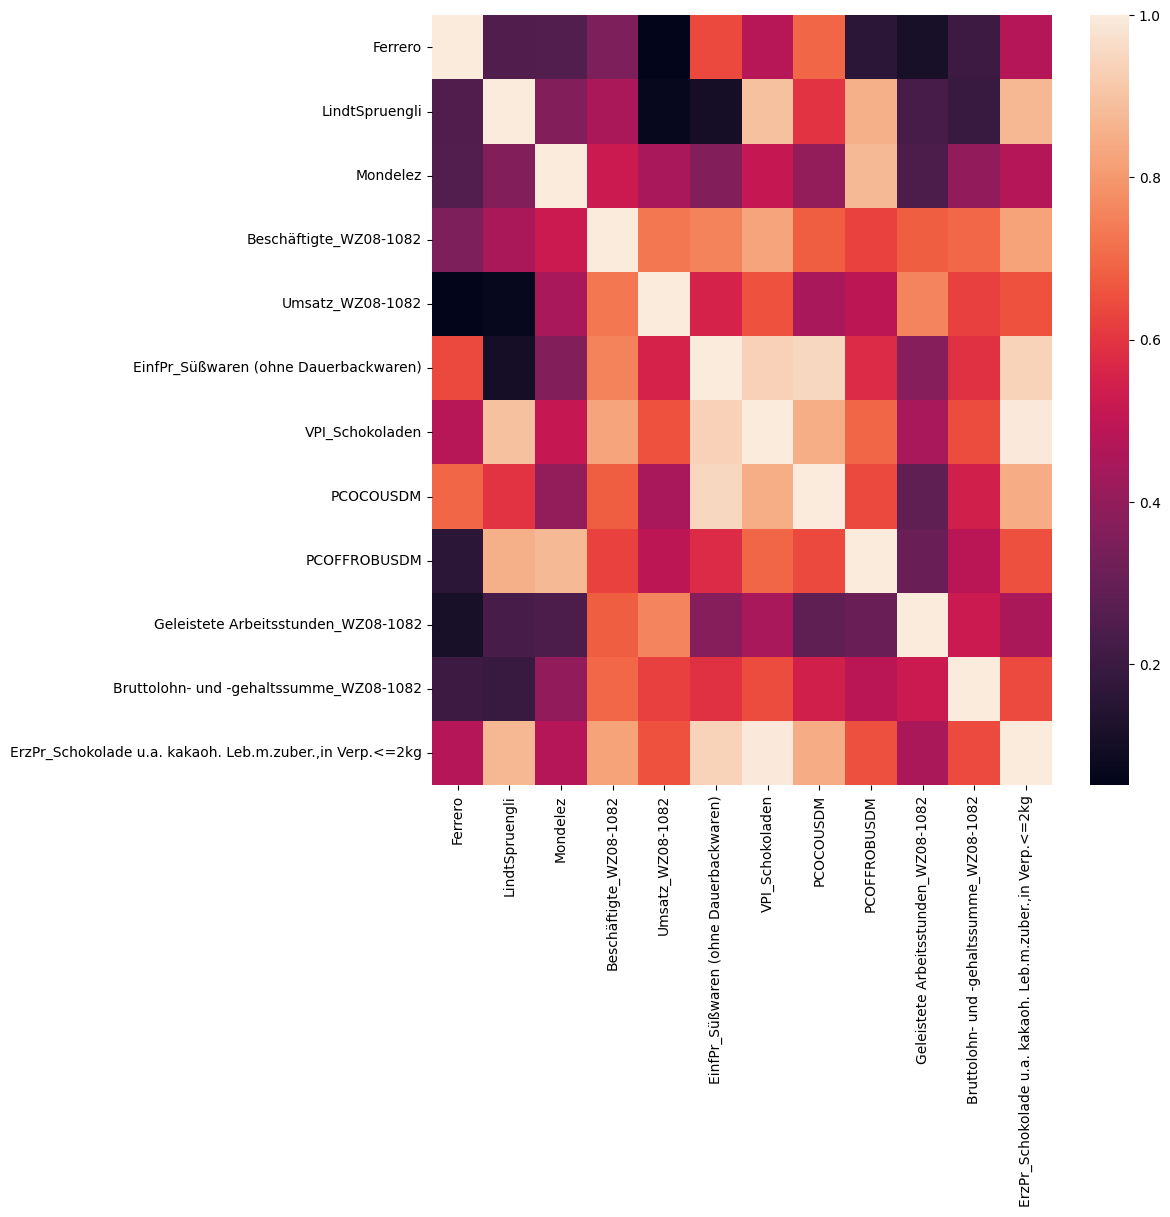

In [51]:
corr = df.loc[:,list(dict_lag)].corr()
fig_heatmap, ax_heatmap = plt.subplots(nrows=1, ncols=1, figsize=(10,10));
sns.heatmap(corr.abs(), xticklabels=True, yticklabels=True, ax=ax_heatmap)

## Linear Regression

MSE on Train set:  50.52007459691119
MSE on Test set:  227.49813215274818


C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.0829222  -0.23894436 -2.75330486 -0.04143435 -0.64835602  2.28941593
  2.2561187   4.0217142   3.3411057   1.33706884 -1.24451719  4.04554774
  1.66805903 -2.10383692 -3.86100675 -1.6144471  -0.72621655  0.53645241
  1.67527037  1.86090186  0.34217982 -2.29273544 -3.64941605 -0.83956679
 -3.44843196 -5.09858044]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -2.328742    -2.01295982  -7.87499356  -5.5085514   -5.91833322
  -6.93828037 -11.06119836 -13.08983522]' has dtype incompatible with int

(              pred_m   pred_mf  pred_mfl     final     target
 index                                                        
 2019-02-28 -0.082922       NaN       NaN -0.082922   2.208051
 2019-03-31 -0.238944       NaN       NaN -0.238944  -0.367747
 2019-04-30 -2.753305       NaN       NaN -2.753305  -1.450762
 2019-05-31 -0.041434       NaN       NaN -0.041434  -0.543008
 2019-06-30 -0.648356       NaN       NaN -0.648356  -1.837945
 ...              ...       ...       ...       ...        ...
 2024-11-30  3.702969  2.899711  8.059380  3.570888   0.306333
 2024-12-31  1.623298  0.602154  6.498711  1.429299  20.434410
 2025-01-31 -2.420870 -3.915855  5.233271 -2.684560   1.778236
 2025-02-28  1.733581  0.012590  4.042900  1.174046   1.563292
 2025-03-31 -0.914675 -2.386850 -0.107381 -1.439304  -0.355388
 
 [74 rows x 5 columns],
                pred_m    pred_mf  pred_mfl      final     target
 index                                                           
 2025-04-30  -2.117813 

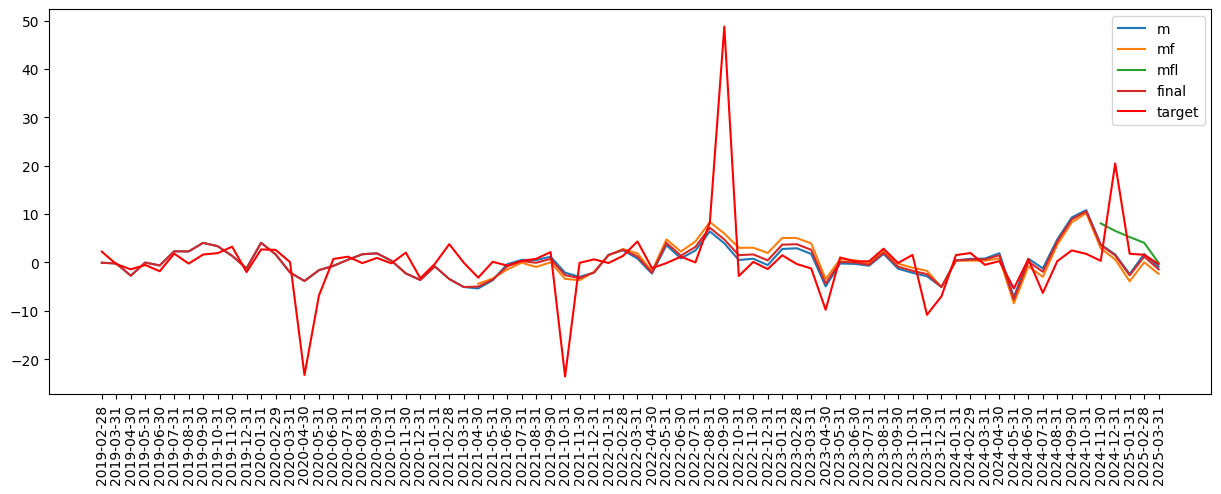

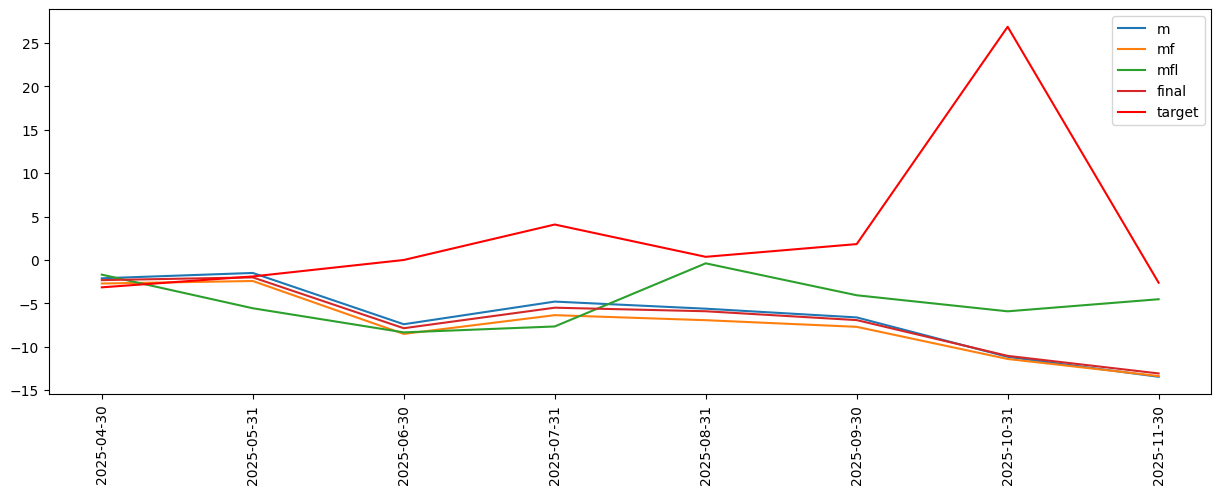

In [52]:
model_start = LinearRegression()
model_middle = LinearRegression()
model_end = LinearRegression()
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name)

## LinearSVR

MSE on Train set:  57.02568719203538
MSE on Test set:  97.1679755319935


C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.00278769 -0.24690909 -1.44726887  0.12459811 -0.72324307  1.81145613
  1.61672837  1.87467574  1.67611739  0.55161033 -1.9375527   1.90228232
  0.57756195 -0.35644253 -2.54024055 -1.97349438 -0.96776313  0.62667474
  0.04564561  1.15826233  0.42630061 -0.64647403 -2.51669446 -0.36518403
 -1.00188209 -0.59690414]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.6538072  -0.52039047 -0.73735154  1.16559688 -0.27984593  0.37272221
 -0.62760303 -1.78008477]' has dtype incompatible with int64, plea

,pred_m,pred_mf,pred_mfl,final,target
index,,,,,
2019-02-28,-0.002788,NaN,NaN,-0.002788,2.208051
2019-03-31,-0.246909,NaN,NaN,-0.246909,-0.367747
2019-04-30,-1.447269,NaN,NaN,-1.447269,-1.450762
2019-05-31,0.124598,NaN,NaN,0.124598,-0.543008
2019-06-30,-0.723243,NaN,NaN,-0.723243,-1.837945
...,...,...,...,...,...
2024-11-30,0.291294,0.294249,2.020513,0.360490,0.306333
2024-12-31,-2.252378,-2.241539,2.642425,-2.055572,20.434410
2025-01-31,1.778236,1.778236,0.604390,1.732021,1.778236


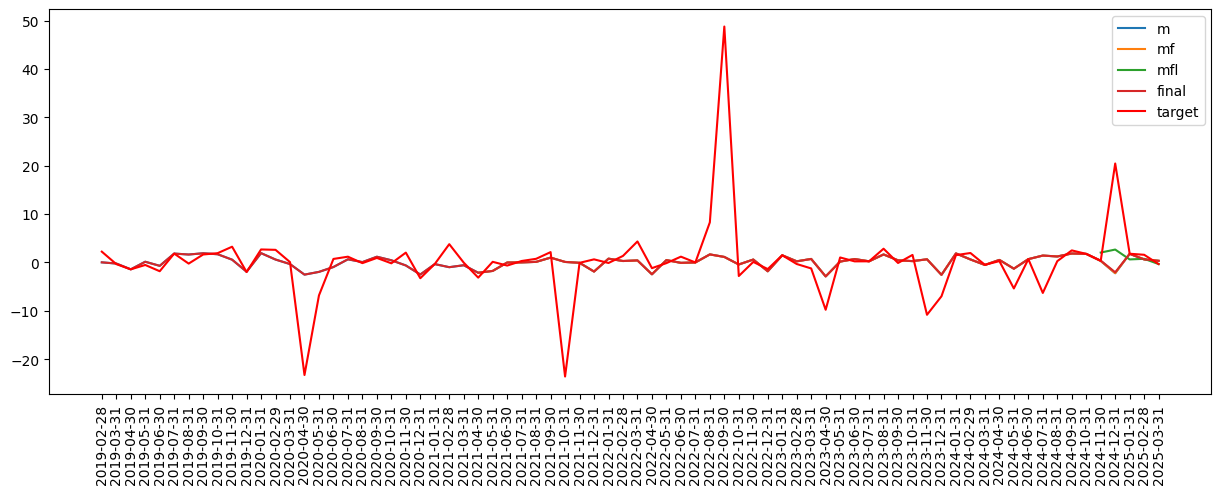

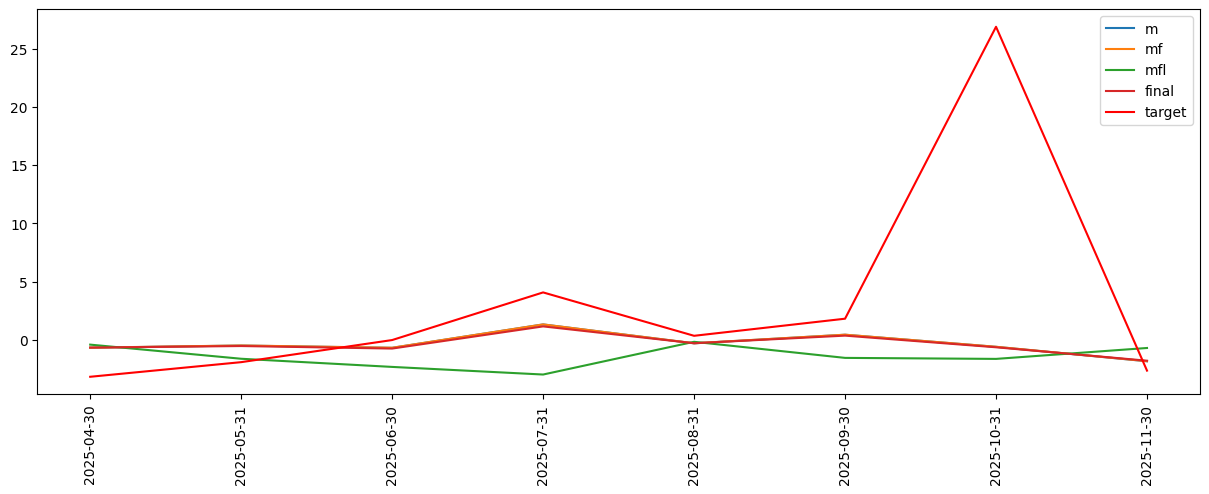

In [54]:
model_start = LinearSVR()
model_middle = LinearSVR()
model_end = LinearSVR()
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name)
results

MSE on Train set:  56.125849849043725
MSE on Test set:  92.65126065612196


C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.02166352 -0.26804845 -1.2800914   0.0921533  -0.78590353  1.36053077
  1.45281716  1.57877194  1.52344298  1.25892771 -1.37059216  1.5308074
  0.57967234 -0.05445724 -1.91198519 -1.45171595 -0.9611047   0.55907371
 -0.06418924  1.16432918  0.7061904   0.7760504  -1.66095567 -0.2259299
 -0.74211538 -0.0546987 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.14613354 1.16259481 0.96038195 1.01596544 0.927717   0.78048111
 0.55404785 0.24351307]' has dtype incompatible with int64, please explici

,pred_m,pred_mf,pred_mfl,final,target
index,,,,,
2019-02-28,-0.021664,NaN,NaN,-0.021664,2.208051
2019-03-31,-0.268048,NaN,NaN,-0.268048,-0.367747
2019-04-30,-1.280091,NaN,NaN,-1.280091,-1.450762
2019-05-31,0.092153,NaN,NaN,0.092153,-0.543008
2019-06-30,-0.785904,NaN,NaN,-0.785904,-1.837945
...,...,...,...,...,...
2024-11-30,0.251473,0.264838,0.406521,0.262629,0.306333
2024-12-31,0.850668,1.103669,1.467672,0.970582,20.434410
2025-01-31,1.480706,1.573436,1.677859,1.523516,1.778236


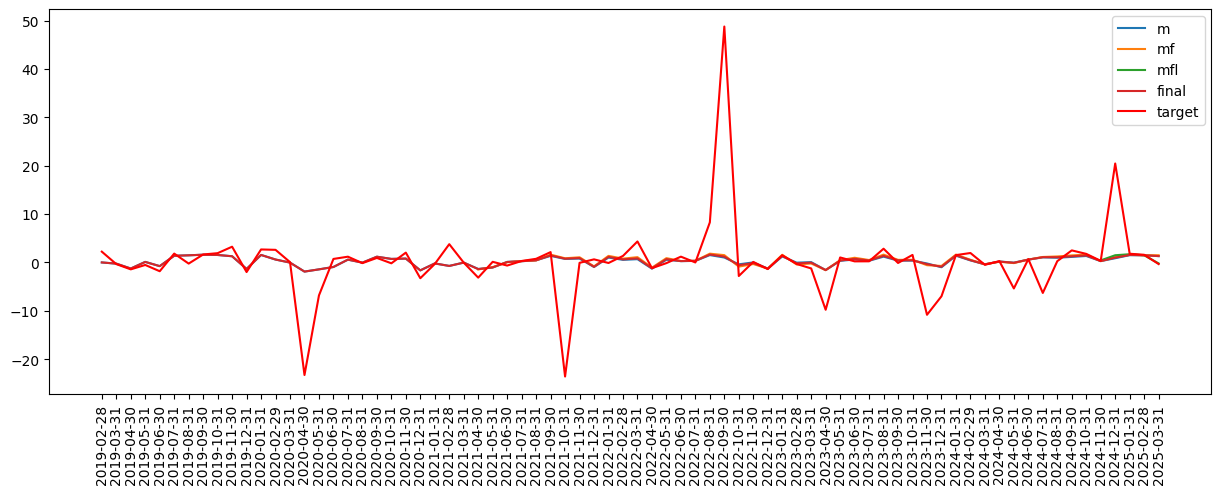

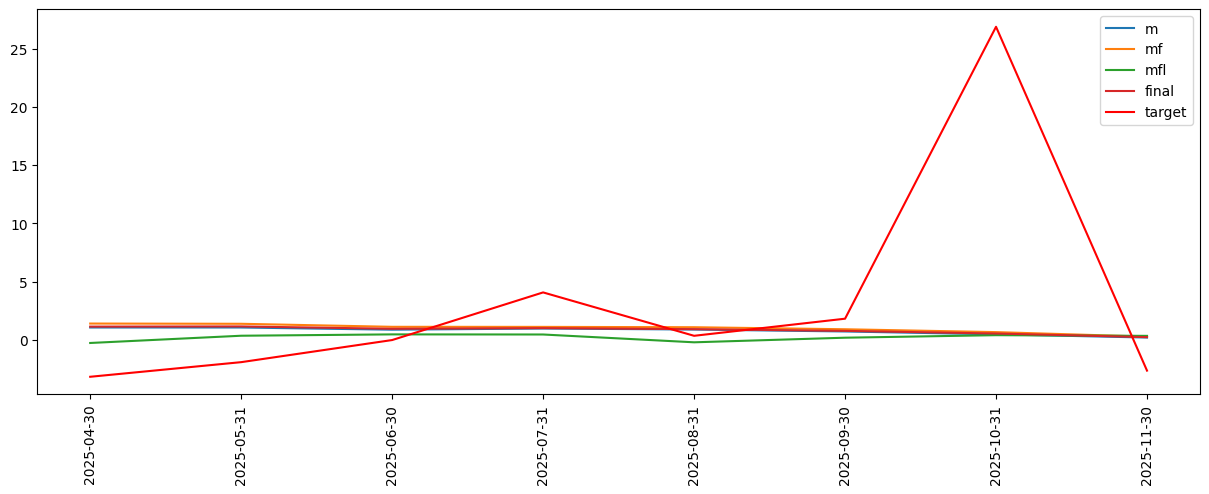

In [55]:
model_start = SVR()
model_middle = SVR()
model_end = SVR()
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name)
results

## Random Forest

MSE on Train set:  13.095087152477033
MSE on Test set:  131.70633382003388


C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  1.48685231   0.97169278   0.50393557   0.18383762  -0.8190706
   0.70424992   0.75330028   1.97550982   1.13280028   0.89278968
  -1.42590315   1.13280028   0.89480375   0.18383762 -14.0670913
  -5.45945701  -0.40400644   0.6411729    0.54755816   0.70424992
   0.89278968   0.46423932  -1.47171794  -0.19566238   0.64794241
   0.0487397 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.30759754  0.09888705  0.09888705  0.27623381 -0.58380741 -5.59480183
 -4.21425286 -4.62569884]' has dtype inco

,pred_m,pred_mf,pred_mfl,final,target
index,,,,,
2019-02-28,1.486852,NaN,NaN,1.486852,2.208051
2019-03-31,0.971693,NaN,NaN,0.971693,-0.367747
2019-04-30,0.503936,NaN,NaN,0.503936,-1.450762
2019-05-31,0.183838,NaN,NaN,0.183838,-0.543008
2019-06-30,-0.819071,NaN,NaN,-0.819071,-1.837945
...,...,...,...,...,...
2024-11-30,0.844136,1.294607,0.306333,0.993219,0.306333
2024-12-31,2.018946,4.939710,20.434410,3.847875,20.434410
2025-01-31,-1.131567,0.618199,1.778236,-0.355679,1.778236


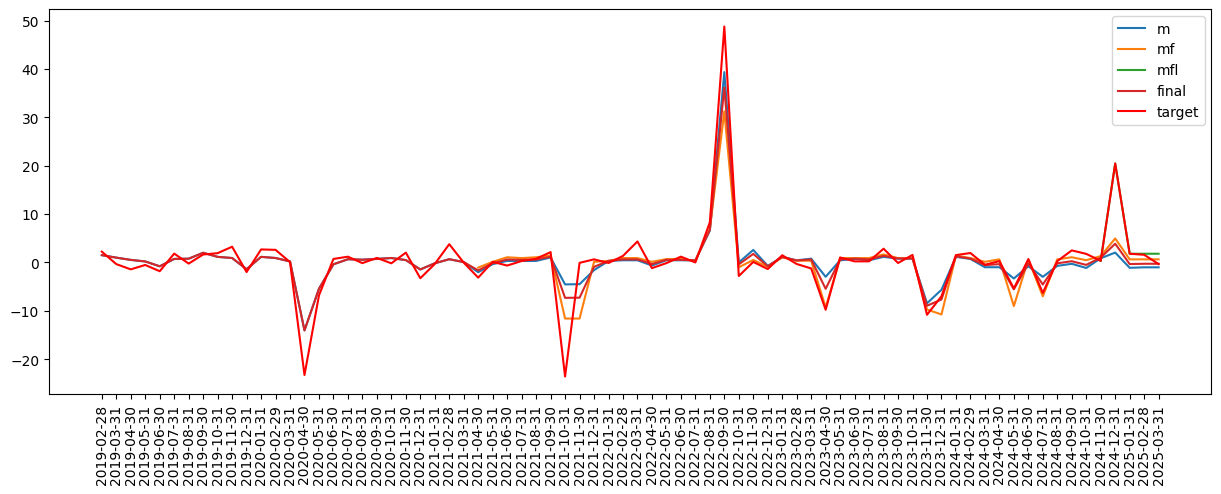

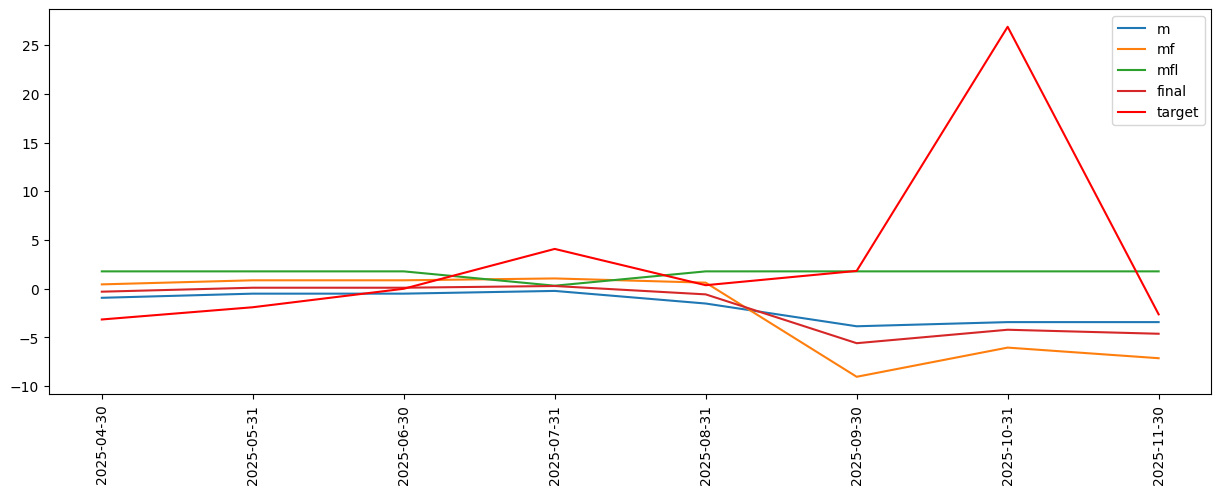

In [58]:
model_start = RandomForestRegressor(n_estimators=5, max_depth=5)
model_middle = RandomForestRegressor(n_estimators=5, max_depth=5)
model_end = RandomForestRegressor(n_estimators=1, max_depth=5)
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name)
results